# **Analysis**

#### Set-Up

In [2]:
# --- Imports ---
import os
import shutil
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.lines as mlines
import numpy as np
from matplotlib.patches import Patch
from pathlib import Path

In [3]:
work_dir = "/jumbo/keller-lab/Jeremy_Wang/eplus_sa/scripts/main" # Change this to your working directory
os.chdir(work_dir) # Set working directory

In [4]:
# --- Load Simulation Results for all seeds ---

# number of sims per seed
num_simulations = 10000

# list your seed directories
seeds = [f"seed_{i}" for i in range(1,21)]

# where your outputs live
output_base = os.path.join(work_dir, "output")

def read_csv_for_sim(task):
    seed, sim_id = task
    folder   = f"randomized_{sim_id}" # sim id is number run within the seed
    csv_file = os.path.join(output_base, seed, folder, "eplusmtr.csv")
    # skip if missing or zero‐byte
    if not os.path.isfile(csv_file) or os.path.getsize(csv_file) == 0:
        return None
    try:
        df = pd.read_csv(csv_file)
    except pd.errors.EmptyDataError:
        return None
    df["Simulation_ID"] = sim_id
    df["seed"]          = seed
    return df

# build the full list of (seed, sim_id) pairs
tasks = [(seed, i) for seed in seeds for i in range(1, num_simulations+1)]

all_dfs = []
max_workers = os.cpu_count() or 4 # returns the number of available cpu cores
print(f"Reading {len(tasks)} files across {len(seeds)} seeds using {max_workers} workers...")

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    future_to_task = {executor.submit(read_csv_for_sim, t): t for t in tasks} # for every task (seed, i) combo, tells the executor to read csv
    for future in as_completed(future_to_task): # as soon as completed, append df into a bigger output
        df = future.result()
        seed, sim_id = future_to_task[future]
        if df is not None:
            all_dfs.append(df)
        else:
            # you can comment this out if it's too noisy
            print(f"Skipping empty/missing file: {seed}/randomized_{sim_id}/eplusmtr.csv")

if not all_dfs:
    raise RuntimeError("No simulation CSV files found. Check your output directories.")

# combine into one big DataFrame
combined_df = pd.concat(all_dfs, ignore_index=True)

Reading 200000 files across 20 seeds using 64 workers...
Skipping empty/missing file: seed_8/randomized_5439/eplusmtr.csv
Skipping empty/missing file: seed_8/randomized_5638/eplusmtr.csv
Skipping empty/missing file: seed_9/randomized_8352/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_549/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_570/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_5490/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_5478/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_5494/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_5497/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_5678/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_5671/eplusmtr.csv
Skipping empty/missing file: seed_15/randomized_5909/eplusmtr.csv
Skipping empty/missing file: seed_20/randomized_5618/eplusmtr.csv


In [5]:
analysis_sim_dir = os.path.join(work_dir, "analysis")
os.makedirs(analysis_sim_dir, exist_ok=True)

# --- Clean analysis output directory ---
for fn in os.listdir(analysis_sim_dir):
    path = os.path.join(analysis_sim_dir, fn)
    if os.path.isfile(path) or os.path.islink(path): 
        os.unlink(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)

In [6]:
# --- CSV output directory ---
csv_out = os.path.join(analysis_sim_dir, "output_csv")
if os.path.isdir(csv_out): shutil.rmtree(csv_out) # removing the folder if it already exists
os.makedirs(csv_out, exist_ok=True)

In [7]:
# Convert columns to numeric
numeric_cols = [
    "Electricity:Facility [J](Monthly)", "Electricity:Building [J](Monthly)", "InteriorLights:Electricity [J](Monthly)",
    "Electricity:Facility [J](RunPeriod)", "Electricity:Building [J](RunPeriod)", "InteriorLights:Electricity [J](RunPeriod)",
    "Electricity:HVAC [J](Monthly)", "NaturalGas:Facility [J](Monthly)", "NaturalGas:HVAC [J](Monthly)",
    "Electricity:HVAC [J](RunPeriod)", "NaturalGas:Facility [J](RunPeriod)", "NaturalGas:HVAC [J](RunPeriod)"
]

for col in numeric_cols:
    if col in combined_df:
        combined_df[col] = pd.to_numeric(combined_df[col], errors="coerce")

# Unit conversions
for col in list(combined_df):
    if col.endswith("[J](Monthly)") or col.endswith("[J](RunPeriod)"):
        combined_df[col.replace("[J]", "[KJ]")] = combined_df[col] / 1e3
        combined_df[col.replace("[J]", "[kWh]")] = combined_df[col] / 3.6e6

BTU_conv = 0.000947817
for col in list(combined_df):
    if "[J](" in col and ("HVAC" in col or "NaturalGas" in col):
        combined_df[col.replace("[J]", "[BTU]")] = combined_df[col] * BTU_conv

# saving converted combined_df values to csv in the folder
combined_df.to_csv(os.path.join(csv_out, "combined_sims.csv"), index=False, float_format="%.2f")

# --- Define month order ---
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

combined_df["Date/Time"] = pd.Categorical(
    combined_df["Date/Time"], categories=month_order, ordered=True
)

In [8]:
# For a variable number of seeds (e.g., 1 to 20)
max_seed = 20  # Change this to the number of seeds you have

for i in range(1, max_seed + 1):
    seed_name = f"seed_{i}"
    # Check if this seed exists in the data before creating the variable
    if seed_name in combined_df["seed"].unique():
        globals()[seed_name] = combined_df[combined_df["seed"] == seed_name] # creates a df for each seed

In [9]:
# Export into CSV files

for i in range(1, 21):
    seed_df = combined_df[combined_df["seed"] == f"seed_{i}"]
    seed_df.to_csv(
        os.path.join(csv_out, f"seed_{i}.csv"),
        index=False,
        float_format="%.2f"
    )

# Running Baseline EnergyPlus Model

In [10]:
# --- Run baseline model ---
baseline_out = os.path.join(analysis_sim_dir, "baseline_run")
if os.path.isdir(baseline_out): shutil.rmtree(baseline_out)
os.makedirs(baseline_out)

idd_file_path = "/jumbo/keller-lab/Applications/EnergyPlus-24-1-0/Energy+.idd"
weather_file  = os.path.join(work_dir, "weather_data", "USA_IL_Chicago-OHare-Intl-AP.725300_AMY_2023.epw")

baseline_idf = "/jumbo/keller-lab/Jeremy_Wang/eplus_sa/data/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf"
subprocess.run([
    "/jumbo/keller-lab/Applications/EnergyPlus-24-1-0/energyplus",
    "--weather", weather_file,
    "--output-directory", baseline_out,
    "--idd", idd_file_path,
    "--annual", "--readvars",
    baseline_idf
], check=True)

# Read baseline CSV
bl_df = pd.read_csv(os.path.join(baseline_out, "eplusmtr.csv"))
bl_df["Facility_kWh"] = pd.to_numeric(bl_df["Electricity:Facility [J](Monthly)"], errors="coerce") / 3.6e6
baseline_total_kwh = bl_df["Facility_kWh"].sum()


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2026.01.25 19:35
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


In [11]:
# convert baseline monthly J to kWh
bl_df["Facility_kWh"] = pd.to_numeric(
    bl_df["Electricity:Facility [J](Monthly)"],
    errors="coerce"
) / 3.6e6

# get baseline by month (must use the same categorical month_order you used above)
baseline_monthly = (
    bl_df
    .groupby("Date/Time")["Facility_kWh"]
    .sum()
    .reindex(month_order)        # ensure same order as facets
)

# Figures

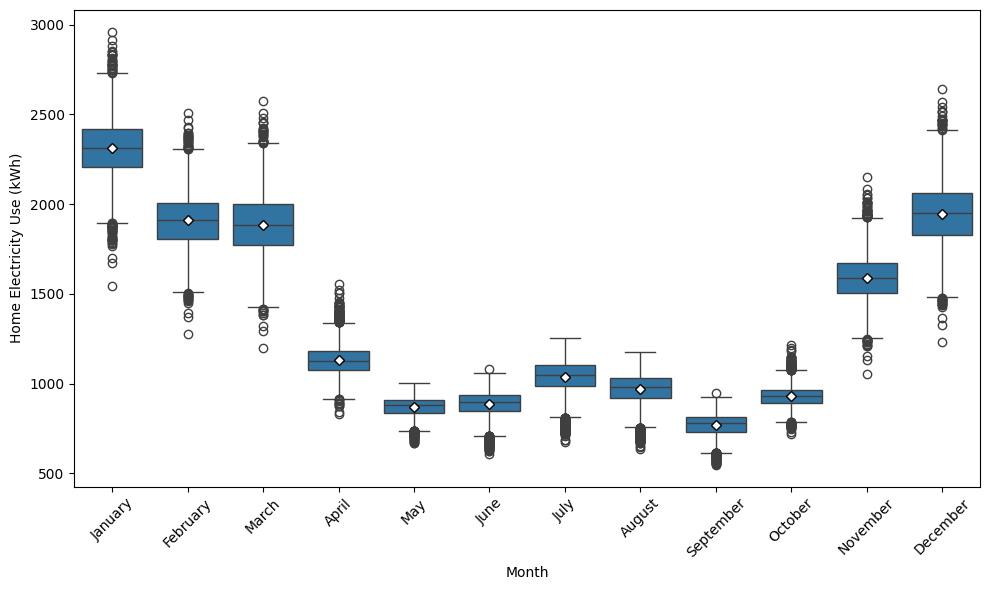

In [20]:
# Boxplot

plt.figure(figsize=(10,6))
sns.boxplot(
    x="Date/Time",
    y="Electricity:Facility [kWh](Monthly)",
    data=seed_1,
    showmeans=True,                        # Show mean markers
    meanprops={"marker":"D",               # Circle marker
               "markerfacecolor":"white",  # White fill
               "markeredgecolor":"black",  # Black edge
               "markersize":"5"}          # Size of marker
)
# plt.title("Parametric Uncertainty Drives Wide Variability in Monthly Facility Electricity")
plt.xlabel("Month")
plt.ylabel("Home Electricity Use (kWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(analysis_sim_dir, "boxplot_joules.png"), dpi=300)
# plt.close()

/tmp/ipykernel_909701/720657676.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_j = seed_1.pivot_table(index="Simulation_ID", columns="Date/Time", values="Electricity:Facility [kWh](Monthly)")


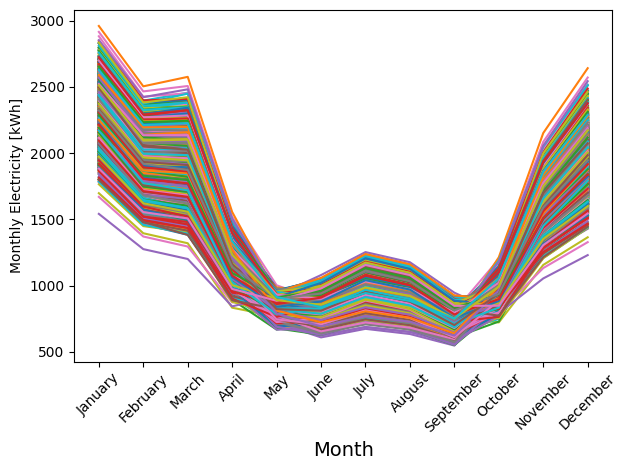

In [21]:
# Define the correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Create pivot table
pivot_j = seed_1.pivot_table(index="Simulation_ID", columns="Date/Time", values="Electricity:Facility [kWh](Monthly)")

# Reorder the columns according to the correct month order
pivot_j = pivot_j[month_order]

# Now transpose and plot
pivot_j.T.plot(legend=False)

# Add axis labels
plt.xlabel("Month", fontsize=14)
plt.ylabel("Monthly Electricity [kWh]")

# Add x-tick labels in correct order if needed
plt.xticks(range(len(month_order)), month_order, rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(analysis_sim_dir, "lineplot_joules.png"), dpi=300)
# plt.close()

/tmp/ipykernel_909701/2757565982.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seed_1


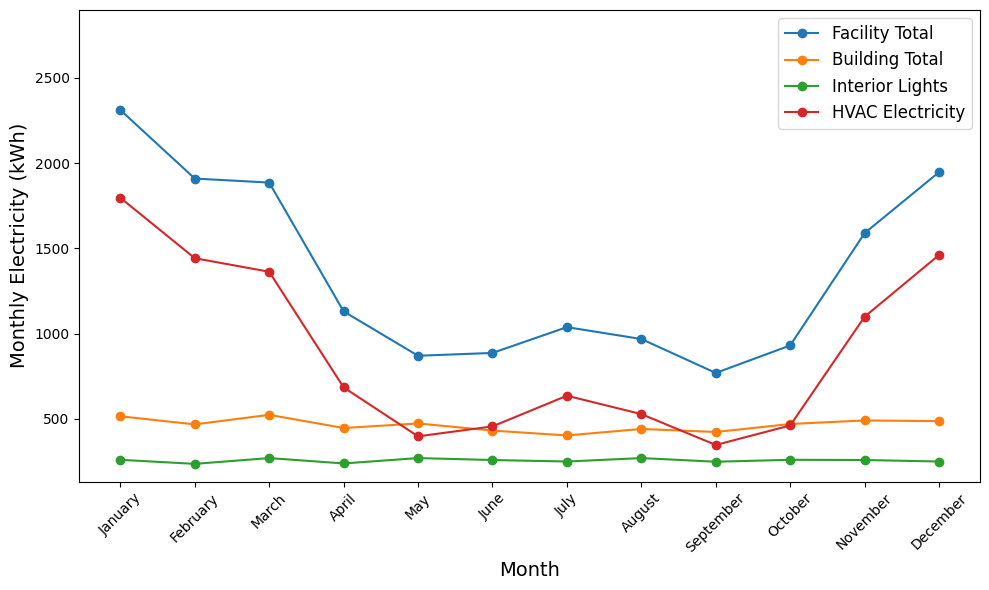

In [22]:
# Monthly average

# Define columns that contain monthly electricity values in kWh
elec_kwh_cols = [
    "Electricity:Facility [kWh](Monthly)",
    "Electricity:Building [kWh](Monthly)",
    "InteriorLights:Electricity [kWh](Monthly)",
    "Electricity:HVAC [kWh](Monthly)"
]

# Map each raw column name to a cleaner legend entry
label_map = {
    "Electricity:Facility [kWh](Monthly)":      "Facility Total",
    "Electricity:Building [kWh](Monthly)":      "Building Total",
    "InteriorLights:Electricity [kWh](Monthly)": "Interior Lights",
    "Electricity:HVAC [kWh](Monthly)":          "HVAC Electricity",
}

# Compute the monthly averages in the right order
avg_df = (
    seed_1
    .groupby("Date/Time")[elec_kwh_cols]
    .mean()
    .reindex(month_order)
    .reset_index()
)

# Plot each series with its pretty label
plt.figure(figsize=(10,6))
for col in elec_kwh_cols:
    plt.plot(
        avg_df["Date/Time"],
        avg_df[col],
        marker="o",
        label=label_map[col]
    )


plt.xticks(rotation=45)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Monthly Electricity (kWh)", fontsize=14)
plt.legend(fontsize=12, title_fontsize=13, loc="upper right")
plt.tight_layout()

# Automatically get current y-axis limit
ymin, ymax = plt.ylim()

# Increase ymax by 10% to make room
plt.ylim(ymin, ymax * 1.2)

plt.savefig(os.path.join(analysis_sim_dir, "avg_electricity_kwh.png"), dpi=300)
plt.show()

/tmp/ipykernel_909701/4267946587.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_monthly_kwh = seed_1.groupby("Date/Time")["Electricity:Facility [kWh](Monthly)"].mean().reindex(month_order)


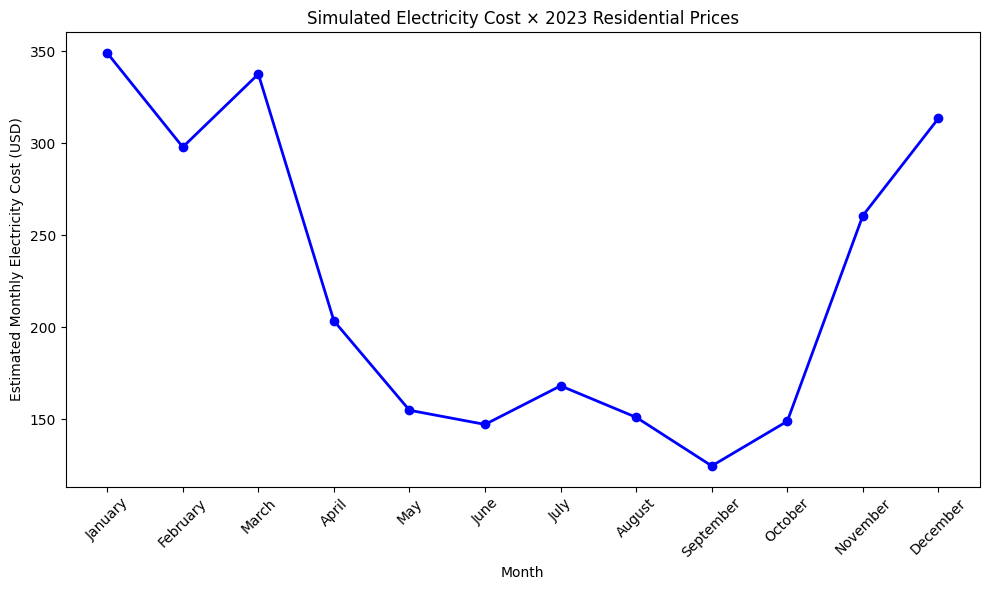

In [23]:
# Compute monthly average electricity use in kWh
avg_monthly_kwh = seed_1.groupby("Date/Time")["Electricity:Facility [kWh](Monthly)"].mean().reindex(month_order)

# Load and prepare electricity price data
price_df = pd.read_csv("../../data/APUS23A72610.csv", parse_dates=["observation_date"])
price_df = price_df[price_df["observation_date"].dt.year == 2023]
price_df["Month"] = price_df["observation_date"].dt.strftime("%B")
price_df["Month"] = pd.Categorical(price_df["Month"], categories=month_order, ordered=True)
price_df = price_df.sort_values("Month")

# Calculate cost by multiplying usage × price (in $/kWh)
monthly_cost_usd = avg_monthly_kwh.values * price_df["APUS23A72610"].values

# Plot
plt.figure(figsize=(10, 6))
plt.plot(month_order, monthly_cost_usd, marker="o", color="blue", linewidth=2)
plt.xlabel("Month")
plt.ylabel("Estimated Monthly Electricity Cost (USD)")
plt.title("Simulated Electricity Cost × 2023 Residential Prices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(analysis_sim_dir, "avg_electricity_cost_2023.png"), dpi=300)
plt.show()

In [24]:
# Ensure 'seed_1' and 'price_df' are loaded and prepared as in your notebook
# And 'month_order' and 'baseline_monthly' (kWh) are also available.

# --- Calculate Monthly Costs for seed_1 data ---
# Create a mapping from month name to price for easier lookup
# Ensure price_df is sorted by 'Month' according to month_order if it's not already
price_df = price_df.set_index("Month").reindex(month_order).reset_index()
month_to_price = pd.Series(price_df['APUS23A72610'].values, index=price_df['Month'])

# Create a copy of seed_1 to avoid modifying the original DataFrame if needed elsewhere
seed_1_costs = seed_1.copy()

# Map prices to each month in seed_1_costs and calculate cost
seed_1_costs['Price_$/kWh'] = seed_1_costs['Date/Time'].map(month_to_price)
seed_1_costs['Monthly_Cost_USD'] = seed_1_costs['Electricity:Facility [kWh](Monthly)'] * seed_1_costs['Price_$/kWh']

# --- Calculate Baseline Monthly Costs ---
# baseline_monthly is assumed to be a Series with kWh values, indexed by month_order
baseline_monthly_cost = baseline_monthly * month_to_price[month_order] # Ensure alignment

# --- Define month order (should be consistent with what's used elsewhere) ---
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

# --- Analysis output directory (ensure it's defined) ---
# analysis_sim_dir = os.path.join(work_dir, "analysis") # From your setup
# os.makedirs(analysis_sim_dir, exist_ok=True) # Ensure it exists

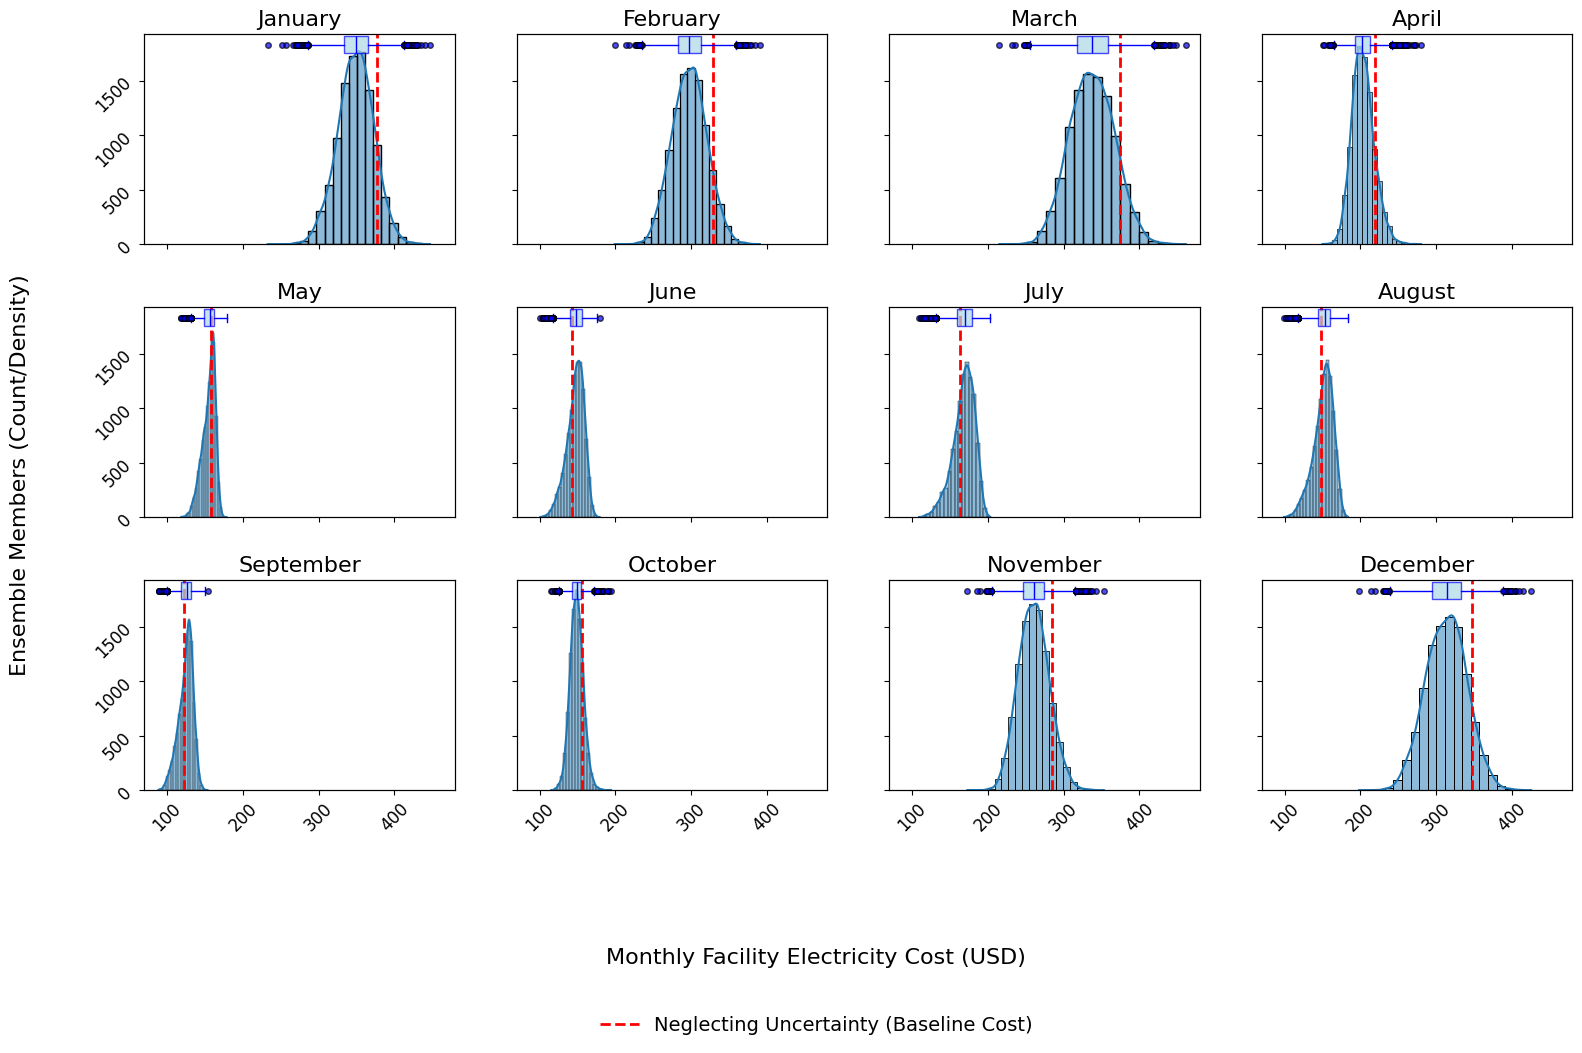

In [33]:
# --- Plotting Monthly Costs ---
  
g = sns.FacetGrid(
    seed_1_costs, # Use the DataFrame with calculated costs
    col="Date/Time",
    col_wrap=4,
    sharex=True, # Consider if costs vary too much for shared X, otherwise keep True
    sharey=True, # Keep True for consistent histogram y-axis (counts/density)
    despine=False,
    height=3.5,
    aspect=1.2
)
  
# Draw the histograms for monthly costs
g.map(
    sns.histplot,
    "Monthly_Cost_USD", # Plot the new cost column
    bins=20, # Adjust bins if necessary for cost distribution
    kde=True
)
  
# Replace titles with just the month name, bigger font
g.set_titles("{col_name}", size=16)
  
# Remove individual axis labels & ticks, but make tick labels larger
for ax in g.axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelrotation=45, labelsize=12) # Keep tick label styling
  
# Overlay the baseline cost line in each facet
for ax, month in zip(g.axes.flatten(), month_order):
    val = baseline_monthly_cost.loc[month] # Use baseline cost for the month
    ax.axvline(val,
               color="red",
               linestyle="--",
               linewidth=2)
    
    # Add boxplot at the top of each facet for monthly costs
    ax2 = ax.twinx()
    
    # Get the cost data for this month
    month_data_cost = seed_1_costs[seed_1_costs["Date/Time"] == month]["Monthly_Cost_USD"]
    
    # Plot the boxplot horizontally at the top
    bp = ax2.boxplot(
        month_data_cost,
        vert=False,
        positions=[0.95], 
        widths=0.08,    
        patch_artist=True,
        showfliers=True  
    )
    
    # Style the boxplot
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color='blue')
    plt.setp(bp['boxes'], facecolor='lightblue', alpha=0.7)
    plt.setp(bp['fliers'], markerfacecolor='blue', markersize=4, alpha=0.7)
    
    # Hide the secondary y-axis details
    ax2.set_yticks([])
    ax2.set_ylim(0, 1) # Relative positioning for boxplot
    
    # Ensure the boxplot uses the same x-range as the histogram
    ax2.set_xlim(ax.get_xlim())
  
# Prepare legend entries (labels remain relevant)
baseline_line = mlines.Line2D(
    [], [], color='red', linestyle='--',
    linewidth=2,
    label='Neglecting Uncertainty (Baseline Cost)' # Slightly more descriptive label
)

# Note: Boxplot legend elements were defined in your original code but not added to this specific legend.
# If you want to add a boxplot legend, you would include boxplot_patch and boxplot_line in the handles.
# For now, following your provided legend setup:
g.fig.legend(
    handles=[baseline_line], # Add other handles if needed (e.g., for boxplot)
    labels=['Neglecting Uncertainty (Baseline Cost)'],
    loc='lower center',
    ncol=1, # Adjust if more legend items
    fontsize=14,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05) # Adjust anchor as needed
)
  
# Adjust spacing and add common labels
g.fig.subplots_adjust(
    top=0.92,
    bottom=0.20, # Increased bottom to make space for new legend/x-axis label
    left=0.10,
    right=0.95,
    hspace=0.3,
    wspace=0.2
)

# Update the common X-axis label
g.fig.text(
    0.5, 0.04, # Adjust vertical position if needed
    "Monthly Facility Electricity Cost (USD)", # Updated label
    ha="center",
    va="center",
    fontsize=16
)

# Common Y-axis label (refers to histogram counts)
g.fig.text(
    0.02, 0.5,
    "Ensemble Members (Count/Density)", # Clarified label
    va="center",
    rotation="vertical",
    fontsize=16
)
  
ncol = 4  # Same as your col_wrap
for idx, ax in enumerate(g.axes.flatten()):
    ax.set_ylabel("") # Handled by common Y-axis label
    if idx % ncol == 0:
        ax.tick_params(axis="y", which="both", left=True, labelleft=True, labelsize=12)
    else:
        ax.tick_params(axis="y", which="both", left=True, labelleft=False)

# Save the new plot with a different name
plt.savefig(
    os.path.join(analysis_sim_dir, "facetgrid_costs_with_baseline_and_boxplot.png"), # New filename
    dpi=300,
    bbox_inches='tight'
)
plt.show()

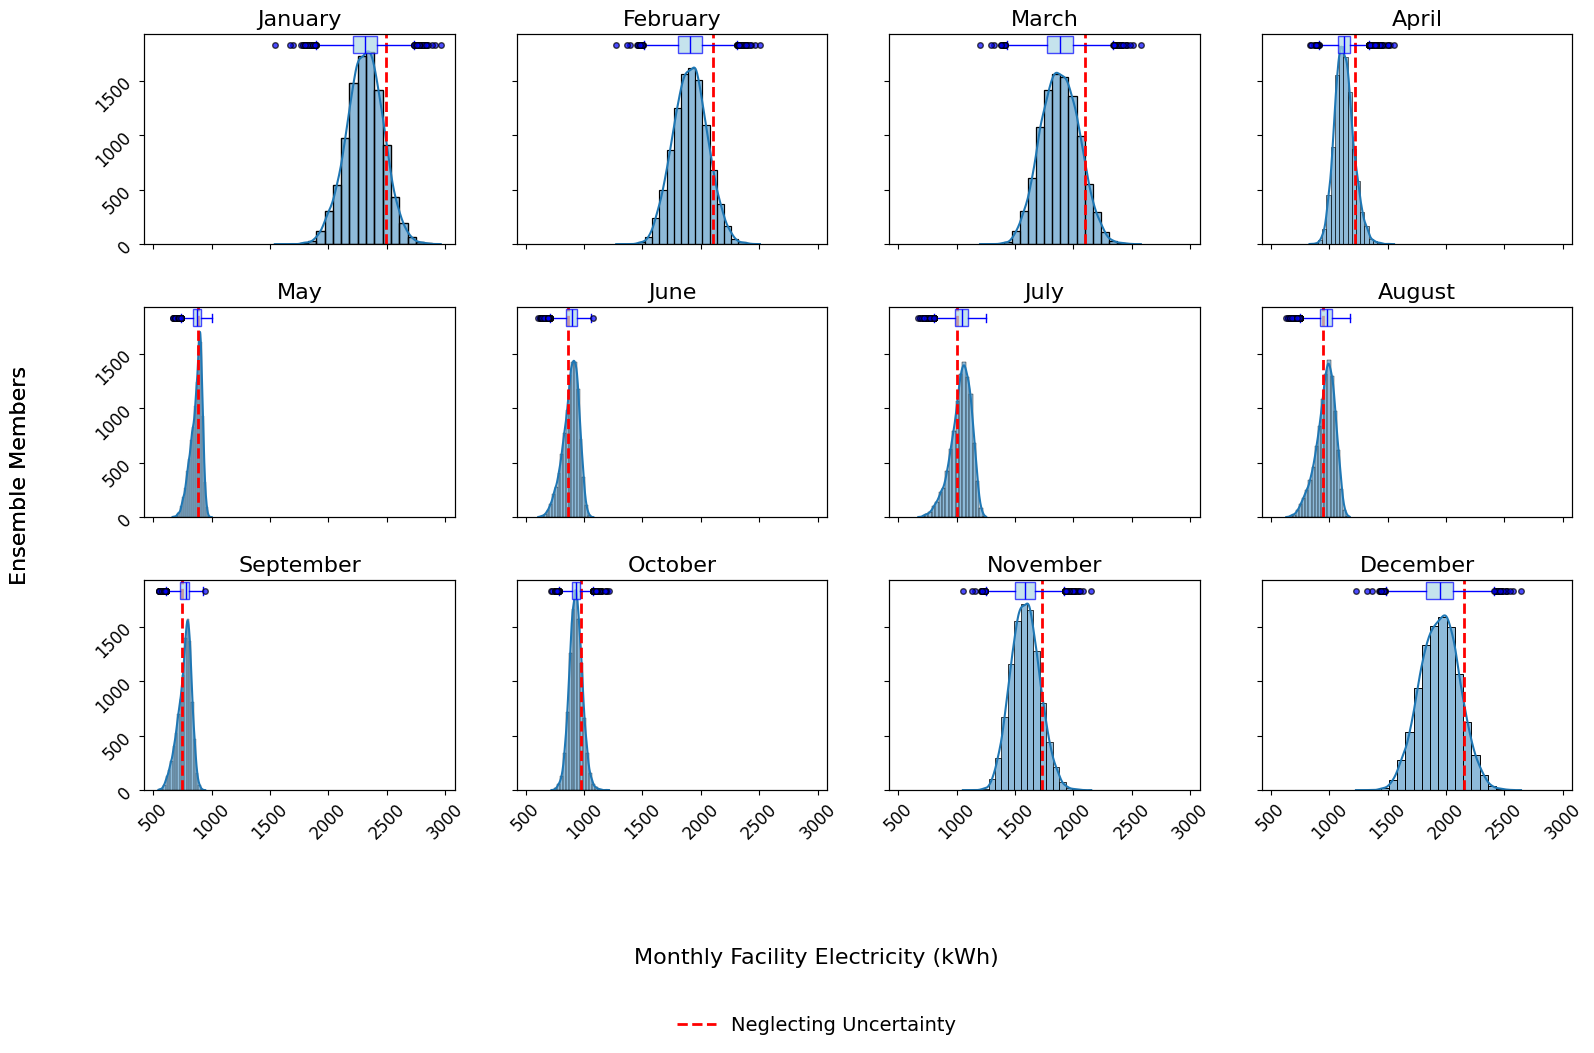

In [26]:
# --- Plotting ---
  
g = sns.FacetGrid(
    seed_1,
    col="Date/Time",
    col_wrap=4,
    sharex=True,
    sharey=True,
    despine=False,
    height=3.5, # bump up the size a bit
    aspect=1.2
)
  
# draw the histograms
g.map(
    sns.histplot,
    "Electricity:Facility [kWh](Monthly)",
    bins=20,
    kde=True
)
  
# replace titles with just the month name, bigger font
g.set_titles("{col_name}", size=16)
  
# remove individual axis labels & ticks, but make tick labels larger
for ax in g.axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelrotation=45, labelsize=12)
  
# overlay the baseline line in each facet
for ax, month in zip(g.axes.flatten(), month_order):
    val = baseline_monthly.loc[month]
    ax.axvline(val,
               color="red",
               linestyle="--",
               linewidth=2)
    
    # Add boxplot at the top of each facet
    # Create a secondary y-axis for the boxplot
    ax2 = ax.twinx()
    
    # Get the data for this month
    month_data = seed_1[seed_1["Date/Time"] == month]["Electricity:Facility [kWh](Monthly)"]
    
    # Plot the boxplot horizontally at the top
    bp = ax2.boxplot(
        month_data,
        vert=False,          # horizontal boxplot
        positions=[0.95],    # position at the top (95% of the y-axis height)
        widths=0.08,         # make the box narrower
        patch_artist=True,   # fill the boxplot
        showfliers=True      # show outliers
    )
    
    # Style the boxplot
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color='blue')
    plt.setp(bp['boxes'], facecolor='lightblue', alpha=0.7)
    plt.setp(bp['fliers'], markerfacecolor='blue', markersize=4, alpha=0.7)
    
    # Hide the secondary y-axis
    ax2.set_yticks([])
    ax2.set_ylim(0, 1)
    
    # Ensure the boxplot uses the same x-range as the histogram
    ax2.set_xlim(ax.get_xlim())
  
# prepare legend entries
baseline_line = mlines.Line2D(
    [], [], color='red', linestyle='--',
    linewidth=2,
    label='Neglecting Uncertainty'
)

boxplot_patch = plt.Rectangle((0, 0), 1, 1, fill=True, color='lightblue', alpha=0.7)
boxplot_line = mlines.Line2D([], [], color='blue', marker='|', linestyle='None', 
                            markersize=10, label='Box & Whisker')
  
# place legend centered below all the facets
g.fig.legend(
    handles=[baseline_line],
    labels=['Neglecting Uncertainty'],
    loc='lower center',
    ncol=3,
    fontsize=14,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)
)
  
# adjust spacing and add common labels
g.fig.subplots_adjust(
    top=0.92,
    bottom=0.20,
    left=0.10,
    right=0.95,
    hspace=0.3,
    wspace=0.2
)
g.fig.text(
    0.5, 0.04,
    "Monthly Facility Electricity (kWh)",
    ha="center",
    va="center",
    fontsize=16
)
g.fig.text(
    0.02, 0.5,
    "Ensemble Members",
    va="center",
    rotation="vertical",
    fontsize=16
)
  
ncol = 4  # same as your col_wrap
for idx, ax in enumerate(g.axes.flatten()):
    # remove the individual axis title
    ax.set_ylabel("")
    # leftmost column?
    if idx % ncol == 0:
        # show tick *labels* on the left
        ax.tick_params(axis="y", which="both", left=True, labelleft=True, labelsize=12)
    else:
        # hide only the tick *labels* (keep tick marks)
        ax.tick_params(axis="y", which="both", left=True, labelleft=False)

# then do your shared y-axis title once on the figure:
g.fig.text(0.02, 0.5, "Ensemble Members", va="center", rotation="vertical", fontsize=16)

plt.savefig(
    os.path.join(analysis_sim_dir, "facetgrid_with_baseline_and_boxplot.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()

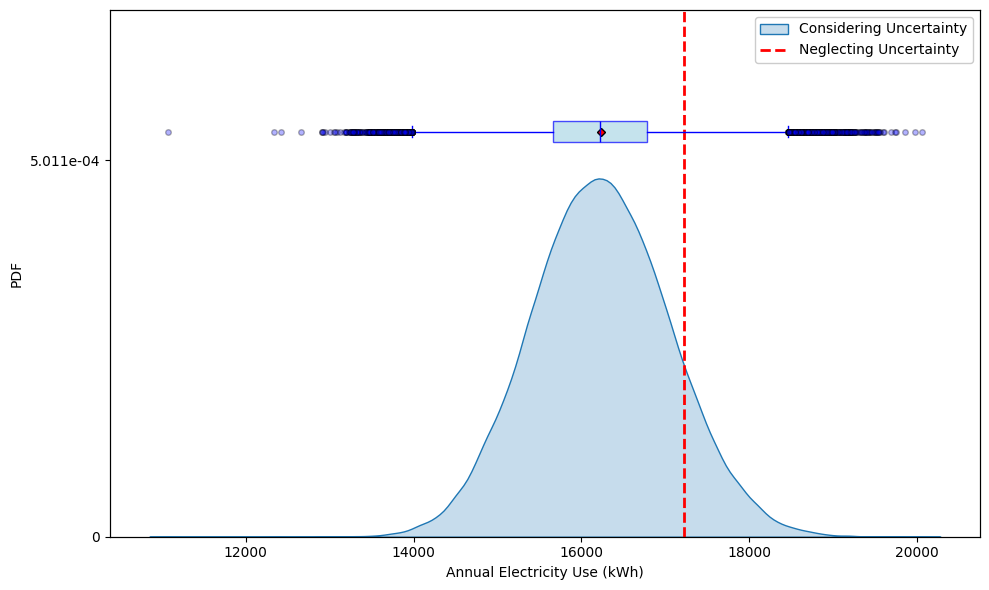

In [27]:
# --- KDE Overlay Plot with Boxplot and Mean Symbol ---

# Create figure and primary axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define your new labels here
new_kde_label = "Considering Uncertainty"
new_axvline_label = "Neglecting Uncertainty"

# Calculate total annual electricity use per simulation
df_tot_kwh = (
    combined_df
    .groupby(["seed", "Simulation_ID"])["Electricity:Facility [kWh](Monthly)"]
    .sum()
    .reset_index()
    .rename(columns={"Electricity:Facility [kWh](Monthly)": "Total_Electricity_kwh"})
)

# Plot KDE on primary axis
sns.kdeplot(data=df_tot_kwh, x="Total_Electricity_kwh", fill=True, label=new_kde_label, ax=ax)
ax.axvline(baseline_total_kwh, color="red", linestyle="--", linewidth=2, label=new_axvline_label)

# Get the current y-limits to understand the KDE plot height
y_min, y_max = ax.get_ylim()

# 5) Adjust y-axis so that only 0 and the max PDF value appear
y_min, y_max = ax.get_ylim()
ax.set_ylim(0, y_max)
ax.set_yticks([0, y_max])
ax.set_yticklabels(["0", f"{y_max:.3e}"])    # scientific notation

# Create a secondary y-axis for the boxplot
ax2 = ax.twinx()

# Get the data for boxplot
boxplot_data = df_tot_kwh["Total_Electricity_kwh"]

# Calculate the position for the boxplot - at the top of the plot
boxplot_position = y_max * 1.15  # Position it higher to avoid legend

# Plot the boxplot horizontally
bp = ax2.boxplot(
    boxplot_data,
    vert=False,                # horizontal boxplot
    positions=[boxplot_position],  # position above the KDE peak
    widths=y_max * 0.06,       # make it a bit narrower
    patch_artist=True,         # fill the boxplot
    showfliers=True            # show outliers
)

# Style the boxplot
for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[element], color='blue')
plt.setp(bp['boxes'], facecolor='lightblue', alpha=0.7)
plt.setp(bp['fliers'], markerfacecolor='blue', markersize=4, alpha=0.3)

# Calculate the mean of the data
mean_value = boxplot_data.mean()

# Add a diamond symbol for the mean
ax2.plot(mean_value, boxplot_position, 
         marker='D',              # Diamond marker
         markersize=4,           # Size of marker
         markerfacecolor='red',   # Red fill
         markeredgecolor='black', # Black edge
         linestyle='None')        # No connecting line

# Hide the secondary y-axis
ax2.set_yticks([])

# Set the y-limits for the boxplot axis
ax2.set_ylim(0, boxplot_position * 1.3)

# Ensure the boxplot uses the same x-range as the KDE plot
ax2.set_xlim(ax.get_xlim())

# Also adjust the primary axis to match
ax.set_ylim(0, y_max * 1.4)  # Give more space above the KDE for the boxplot

# Only include KDE and baseline in the legend (no boxplot)
# Position the legend at the upper right corner
ax.legend(loc='upper right', framealpha=1.0)

# Set labels
ax.set_xlabel("Annual Electricity Use (kWh)")
ax.set_ylabel("PDF")

# Add more top margin to accommodate the boxplot
plt.subplots_adjust(top=0.5)

plt.tight_layout()
plt.savefig(os.path.join(analysis_sim_dir, "kde_with_baseline_and_boxplot.png"), dpi=300)
plt.show()

In [35]:
# --- Prepare Data for Annual Cost KDE Plot ---

# Ensure 'combined_df', 'price_df', 'baseline_monthly', and 'month_order' are available
# and 'analysis_sim_dir' is defined.

# Create/reuse the month_to_price mapping (from previous FacetGrid preparation)
# This assumes price_df is processed as before:
# price_df_sorted = price_df.set_index("Month").reindex(month_order).reset_index() # Ensure it's sorted by month_order
# month_to_price = pd.Series(price_df_sorted['APUS23A72610'].values, index=price_df_sorted['Month'])
# If price_df is already properly indexed by 'Month' in month_order:
if not isinstance(price_df.index, pd.CategoricalIndex) or not price_df.index.categories.equals(pd.Index(month_order)):
    price_df_for_map = price_df.set_index("Month").reindex(month_order)
else:
    price_df_for_map = price_df
month_to_price = pd.Series(price_df_for_map['APUS23A72610'].values, index=price_df_for_map.index)


# 1. Calculate Total Annual Cost for Each Simulation
# Create a temporary dataframe with monthly kWh and map prices
temp_df_annual_cost = combined_df[['seed', 'Simulation_ID', 'Date/Time', 'Electricity:Facility [kWh](Monthly)']].copy()
temp_df_annual_cost['Price_$/kWh'] = temp_df_annual_cost['Date/Time'].map(month_to_price)
temp_df_annual_cost['Monthly_Cost_USD'] = temp_df_annual_cost['Electricity:Facility [kWh](Monthly)'] * temp_df_annual_cost['Price_$/kWh']

# Sum monthly costs to get total annual cost per simulation
df_tot_annual_cost = (
    temp_df_annual_cost.groupby(['seed', 'Simulation_ID'])['Monthly_Cost_USD']
    .sum()
    .reset_index()
    .rename(columns={'Monthly_Cost_USD': 'Total_Annual_Cost_USD'})
)

# 2. Calculate Baseline Total Annual Cost
# baseline_monthly is the Series of baseline kWh per month, indexed by month_order
# baseline_monthly_cost_series = baseline_monthly * month_to_price[month_order] # This gives monthly costs for baseline
# baseline_total_annual_cost = baseline_monthly_cost_series.sum()
# Or, if baseline_monthly_cost (Series of monthly baseline costs) from previous plot is available:
# baseline_total_annual_cost = baseline_monthly_cost.sum()
# Let's recalculate for clarity, ensuring alignment:
# Ensure baseline_monthly is indexed appropriately (e.g., by month strings in month_order)
aligned_prices = month_to_price.reindex(baseline_monthly.index) # Align price series with baseline_monthly's index
baseline_total_annual_cost = (baseline_monthly * aligned_prices).sum()

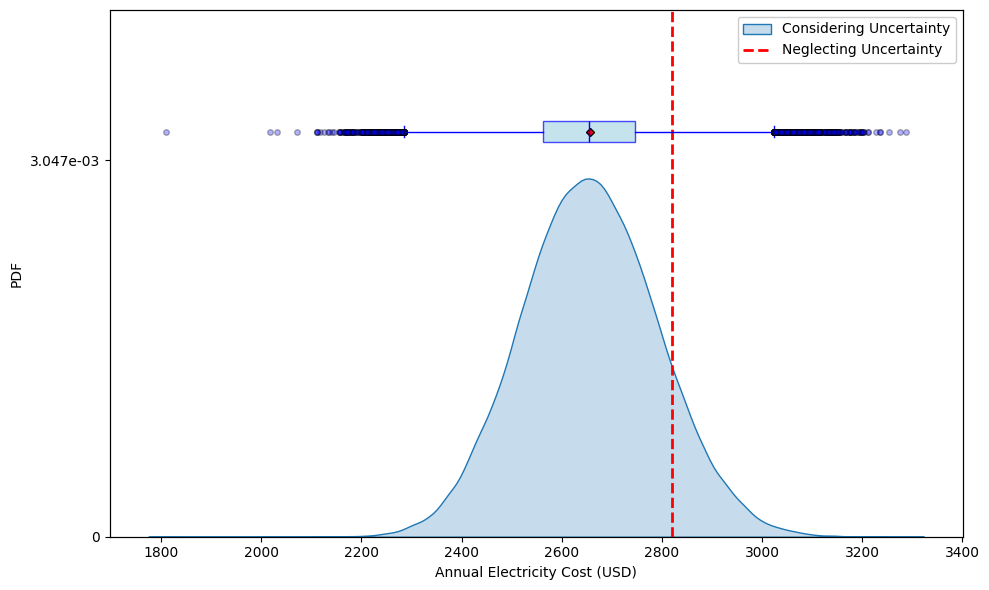

In [37]:
# --- KDE Overlay Plot for Annual Costs with Boxplot and Mean Symbol ---

# Create figure and primary axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define labels (can remain the same conceptually)
new_kde_label = "Considering Uncertainty"
new_axvline_label = "Neglecting Uncertainty"

# Plot KDE of total annual costs on primary axis
sns.kdeplot(data=df_tot_annual_cost, x="Total_Annual_Cost_USD", fill=True, label=new_kde_label, ax=ax)
ax.axvline(baseline_total_annual_cost, color="red", linestyle="--", linewidth=2, label=new_axvline_label)

# Get the current y-limits to understand the KDE plot height
y_min_kde, y_max_kde = ax.get_ylim()

# Adjust y-axis for KDE so that only 0 and the max PDF value appear
ax.set_ylim(0, y_max_kde)
ax.set_yticks([0, y_max_kde])
ax.set_yticklabels(["0", f"{y_max_kde:.3e}"])  # scientific notation for PDF max

# Create a secondary y-axis for the boxplot
ax2 = ax.twinx()

# Get the data for boxplot (total annual costs)
boxplot_data_cost = df_tot_annual_cost["Total_Annual_Cost_USD"]

# Calculate the position for the boxplot - at the top of the plot
boxplot_position_cost = y_max_kde * 1.15  # Position it higher, relative to KDE peak

# Plot the boxplot horizontally
bp_cost = ax2.boxplot(
    boxplot_data_cost,
    vert=False,
    positions=[boxplot_position_cost],
    widths=y_max_kde * 0.06,  # Width relative to KDE height
    patch_artist=True,
    showfliers=True
)

# Style the boxplot
for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp_cost[element], color='blue')
plt.setp(bp_cost['boxes'], facecolor='lightblue', alpha=0.7)
plt.setp(bp_cost['fliers'], markerfacecolor='blue', markersize=4, alpha=0.3)

# Calculate the mean of the annual cost data
mean_annual_cost = boxplot_data_cost.mean()

# Add a diamond symbol for the mean on the boxplot's level
ax2.plot(mean_annual_cost, boxplot_position_cost,
         marker='D',
         markersize=4,
         markerfacecolor='red',
         markeredgecolor='black',
         linestyle='None')

# Hide the secondary y-axis ticks and labels
ax2.set_yticks([])

# Set the y-limits for the boxplot axis to give it space
ax2.set_ylim(0, boxplot_position_cost * 1.3) # Ensure boxplot and mean symbol are visible

# Ensure the boxplot uses the same x-range as the KDE plot
ax2.set_xlim(ax.get_xlim())

# Also adjust the primary KDE axis to make space for the boxplot above it
ax.set_ylim(0, y_max_kde * 1.4) # Give more space above the KDE for the boxplot

# Legend: Only include KDE and baseline line. Position at the upper right.
ax.legend(loc='upper right', framealpha=1.0)

# Set labels
ax.set_xlabel("Annual Electricity Cost (USD)") # Updated x-axis label
ax.set_ylabel("PDF") # Probability Density Function

# Adjust layout to prevent cutting off elements
plt.tight_layout() 

# Save the figure
plt.savefig(os.path.join(analysis_sim_dir, "kde_costs_with_baseline_and_boxplot.png"), dpi=300) # New filename
plt.show()

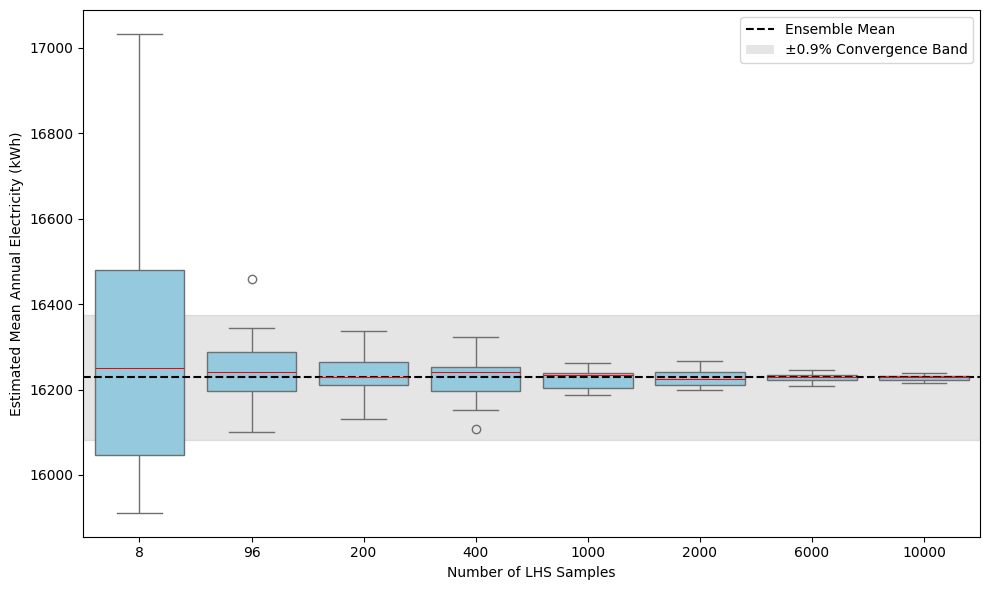

In [73]:
# Compute per‐seed, per‐sim total annual kWh
df_tot_kwh = (
    combined_df
    .groupby(['seed','Simulation_ID'])['Electricity:Facility [J](Monthly)']
    .sum()
    .div(3.6e6) # J → kWh
    .reset_index(name='Total_kWh')
)

# Create "true" mean across ALL seeds & sims
true_mean = df_tot_kwh['Total_kWh'].mean()

# Build convergence records (one mean per seed per sample‐size)
sample_sizes = [8, 96, 200, 400, 1000, 2000, 6000, 10000]
conv_records = []
rngs = {seed: np.random.default_rng(int(seed.split('_')[1]))
        for seed in df_tot_kwh['seed'].unique()}

for x in sample_sizes:
    for seed, rng in rngs.items():
        sim_kwh = df_tot_kwh[df_tot_kwh['seed']==seed]
        sims = sim_kwh['Simulation_ID'].values
        # seed 8 - 9998, seed 9 - 9999, seed 15 - 9991, seed 20 - 9999
        # adding skip if the sampling size is greater than number of simulated values
        if x > len(sims):
            continue

        drawn = rng.choice(sims, size=x, replace=False)
        mu = sim_kwh.loc[sim_kwh['Simulation_ID'].isin(drawn),'Total_kWh'].mean()
        conv_records.append({
            'sample_size': x,
            'mean_kwh': mu
        })

conv_df = pd.DataFrame(conv_records)

# Create boxplot with convergence band
plt.figure(figsize=(10,6))

# Calculate reference median and convergence band (±5%)
reference_sample_size = 10000  # Your largest sample size
threshold_percentage = 0.9
lower_threshold = true_mean * (1 - threshold_percentage/100)
upper_threshold = true_mean * (1 + threshold_percentage/100)

# Add grey convergence band first (so it's behind the boxplot)
plt.axhspan(lower_threshold, upper_threshold, color='grey', alpha=0.2)

# Create the boxplot
sns.boxplot(
    data=conv_df,
    x='sample_size',
    y='mean_kwh',
    color='skyblue',
    showfliers=True,
    medianprops={'color': 'red', 'linewidth': 0.75} # Set median line to red
)

# Add the ensemble mean line
plt.axhline(
    true_mean,
    color='black',
    linestyle='--',
    linewidth=1.5,
    label='Ensemble Mean'
)

# Add legend with both the ensemble mean and convergence band
legend_elements = [
    plt.Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label='Ensemble Mean'),
    Patch(facecolor='grey', alpha=0.2, label=f'±{threshold_percentage}% Convergence Band')
]
plt.legend(handles=legend_elements)

plt.xlabel("Number of LHS Samples")
plt.ylabel("Estimated Mean Annual Electricity (kWh)")
plt.tight_layout()
plt.savefig(
    os.path.join(analysis_sim_dir, "convergence_boxplot_all_seeds.png"),
    dpi=300
)
plt.show()


In [72]:

df_tot_kwh[df_tot_kwh['seed'] == 'seed_1']

,seed,Simulation_ID,Total_kWh
0,seed_1,1,16672.320603
1,seed_1,2,15229.299119
2,seed_1,3,15996.930100
3,seed_1,4,17537.444005
4,seed_1,5,16515.768543
...,...,...,...
9995,seed_1,9996,16610.536465
9996,seed_1,9997,14561.968945
9997,seed_1,9998,16523.829840
9998,seed_1,9999,17260.180544
